# Naïve Bayes (Hyperparameter Tuning)

> Naïve Bayes Algorithm Tuning, Grid Search, Cross Validation, Model Evaluation Metrics, Classification Report, Confusion Matrix and ROC Curve.

- toc: true 
- badges: true
- comments: true
- categories: [Naïve Bayes, Hyperparameter Tuning, Machine Learning, Grid Search, Cross Validation, Model Evaluation Metrics, Classification Report, Confusion Matrix, ROC Curve]

## 1) Import libraries and define functions

### 1.1) Install libraries

In [ ]:
!pip install word2number &> /dev/null

### 1.2) Import libraries

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from word2number import w2n
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, ClassificationReport

nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.3) Define functions for later use

In [ ]:
# This line will disappear in the portfolio page
# 1: Function to turn number words into numbers
def numeric_words_converter(list_words):
  back_to_list =[]
  for string in list_words:
    try:
        value = w2n.word_to_num(string)
        if string=='point':
            value = string
    except:
        value=string
    back_to_list.append(value)
  return back_to_list

## 2) Exploratory Data Analysis (EDA)

### 2.1) Load File

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/leonardodecastro/data/main/SMSSpamCollection.csv')
data.head(2)

,Type of SMS,SMS content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


### 2.2) Clean sentences

- We will use a **function for the second cleaning procedure** since it would be complicated to do so with a lambda function.
- The first cleaning procedure turns strings in each cell into lists. This means that the **lambda functions employed in this analysis are slightly different from lambda functions that are often used in dataframes without lists as cell values**.

In [ ]:
# This line will disappear in the portfolio page
#### 1) Remove punctuaction
tokenizer = nltk.RegexpTokenizer(r"\w+")
data['SMS content'] = data['SMS content'].apply(lambda word_string: tokenizer.tokenize(word_string))

#### 2) Remove all numbers from the SMS messages
# 2.1) Turn number words into numbers
data['SMS content'] = data['SMS content'].apply(numeric_words_converter)

# 2.2) Eliminate numbers
data['SMS content'] = data['SMS content'].apply(lambda list_words: [word for word in list_words if type(word) == str])

# 2.3) Eliminate strings with numbers
data['SMS content'] = data['SMS content'].apply(lambda list_words: [word for word in list_words if not re.search(r'\d',word)])

#### 3) Change all SMS messages to lower case
data['SMS content'] = data['SMS content'].apply(lambda list_words:[word.lower() for word in list_words])

#### 4) Remove stop words from the SMS messages
data['SMS content'] = data['SMS content'].apply(lambda list_words:[word for word in list_words if word not in STOPWORDS])

#### 5) Eliminate single letters
data['SMS content'] = data['SMS content'].apply(lambda list_words:[word for word in list_words if len(word) > 1])

#### 6) Turn lists of words into a single string
data['SMS content'] = data['SMS content'].apply(lambda list_words:' '.join([str(word) for word in list_words]))

#### 7) Visualize dataset
data.head(2)

,Type of SMS,SMS content
0,ham,go jurong point crazy available bugis great wo...
1,ham,ok lar joking wif oni


### 2.3) Turn the target variable into binary variables (1 for Spam and 0 for Ham)

In [ ]:
data['Type of SMS'] = data['Type of SMS'].map({'spam':1,'ham':0})

## 3) Split and scale data

- Naïve Bayes is not affected by scaling. Thus, we will not scale the numbers obtained using the count vectorizer.
- We neet to convert text into numerical data using the CountVectorizer so as to train a Naïve Bayes classifier.

In [ ]:
# This line will disappear in the portfolio page
# Determine which variables are the features and which variable is the target - 
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['SMS content'])
y = data['Type of SMS']

#  Split the dataframe into the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=42, stratify=y)

## 4) Hyperparameter tuning 

- We apply the multinomial Naïve Bayes classifier, where the features are assumed to be generated from a simple multinomial distribution.

- The multinomial Naïve Bayes classifier is suitable for classification of this SMS data with discrete features.

- The multinomial Naïve Bayes classifier, compared to the binomial Naïve Bayes takes into account the frequency of occurance of words (features) in each record. While this may not make much of a difference when the features (words) are hetergeneous (as is the case here), multinomial bayes classifier will work very well in all cases and we therefore decided to use it as our classifier.  

- Guassian based Naive Bayes classifier imposes a Gaussian distribution on the occurance of a feature(word) in a message. The distribution is not continuous and further, it does make sense to impose a mean, std. devation for any feature (word) given that SMS messages could be about anything and assuming a Guassian distribution in unecessarily restrictive.

### 4.1) Calculate a wide range of metrics for model evaluation

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Create a dictionary to store the metrics for different alpha values
scores_dict = {}

# Step 2: Train model for different alpha values (Laplace/Lidstone) smoothing parameter)
for alpha in np.arange(0.01, 10, 0.01):
  # Part 1: Select classifier object
  clf = MultinomialNB(alpha=alpha)
  # Part 2: Determine the metrics that will be analyzed
  scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}
  # Part 3: Calculate metrics using cross-validation
  scores = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring)
  # Part 4: Extract the mean of each one of the metrics
  scores_dict[alpha] = {'accuracy': scores['test_accuracy'].mean(), 'precision': scores['test_precision'].mean(),
                    'recall': scores['test_recall'].mean(), 'f1': scores['test_f1'].mean()}

# Step 3: Create a dataframe with model metrics
metrics_df = pd.DataFrame.from_dict(scores_dict, orient='index').rename_axis('alpha').reset_index()

### 4.2) Plot metrics for different alpha values

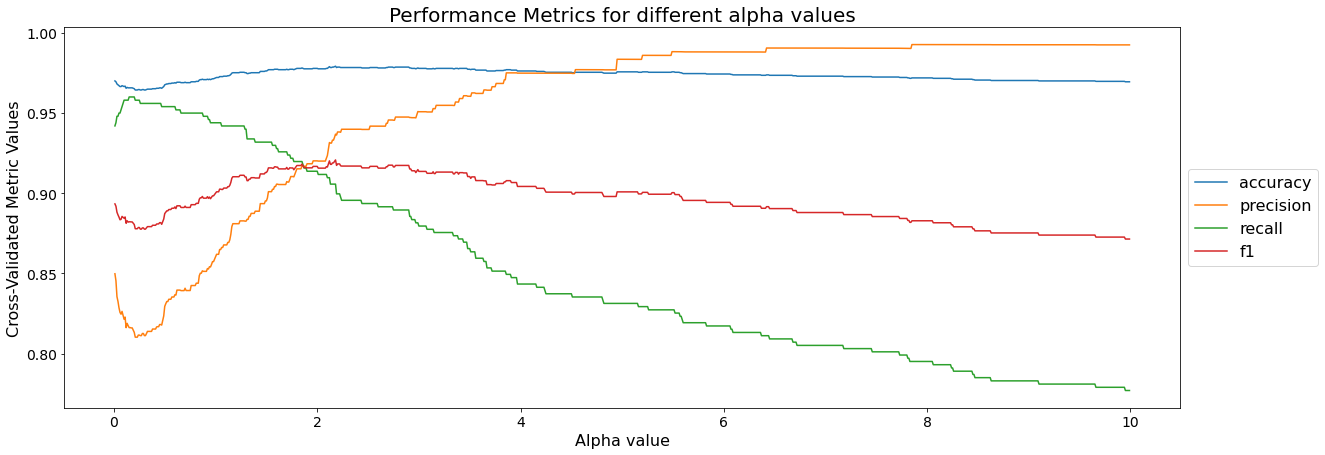

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Melt the dataframe to allow for an easy way to plot with seaborn
metrics_df_melted = pd.melt(metrics_df, id_vars =['alpha'], value_vars =['accuracy', 'precision','recall', 'f1'])

# Step 1: Set parameters for the visualization
plt.rcParams.update({'figure.figsize':(20,7),'axes.titlesize': 20,'axes.labelsize': 16,'xtick.labelsize': 14,'ytick.labelsize': 14})

# Step 2: Generate visualization
sns.lineplot(x="alpha", y="value", hue="variable", data=metrics_df_melted)
plt.title("Performance Metrics for different alpha values")
plt.ylabel('Cross-Validated Metric Values')
plt.xlabel('Alpha value')
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", fontsize=16)
plt.show()

### 4.3) Determine the alpha value that optimizes precision

For the sake of this analysis, we will consider that the effect of predicting that a certain message is SPAM when it is not is much more negative than not spotting a SPAM attempt. After all, if too many messages end up in the SPAM folder, clients might miss important information. On the other hand, too many SPAM messages might annoy users. Thus, we should seek to maximize f1 since it provides a balance between precision and recall.

In [ ]:
ideal_alpha_value = metrics_df.sort_values('f1', ascending = False)['alpha'].to_list()[0]

## 5) Evaluation of optimal model metrics

### 5.1) Classification Report, ROC Curve and Confusion Matrix 

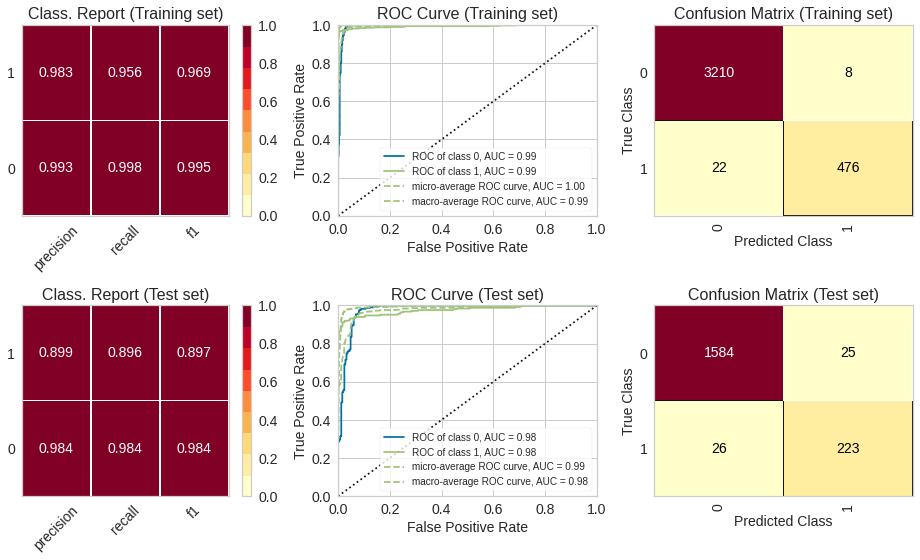

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier
model = MultinomialNB(alpha=ideal_alpha_value)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)"),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)"),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

We can see that the metrics for the training and test set are fairly similar, which indicates that there is **no problem with overfitting or underfitting**. Moreover, the ROC curve indicates that the classifier **outperforms a random classifier** (the baseline). 

## 6) Final considerations

### 6.1) Is the classifier is well-suited for the data set?

1. The multinomial Naïve Bayes classifier is suitable for classification with discrete features. It represents the probability of counts among different categories, and thus multinomial naive Bayes is appropriate for features that represent counts or count rates. Notice that the features in our dataset are all categorial values as they are all the words. In addition, the features in our dataset are the counts of the words. As such, the Naïve Bayes classifier would be a good option for training the dataset on top of all;

2. Since each of the single word from the dataset is treated as a feature, we have thousands of words and thus thousands of features in total. Our Naïve Bayes classifier works well on handling this huge amount of features, and even works well when there is a huge amount of irrelavant features (for example, some words are existed in both ham and spam messages) from the dataset.

3. The "naive" in naive bayes classifier is due to the class conditional independence of features. In the case of SMS messages, naive bayes classifier assumes that the words in the SMS messages (features) are class conditionally independent of each other. i.e. the assumption is that there is less dependence between words used in any given SMS message. This, is not true in general (We don't form a sentence using a set of randomly picked words). Even so, this method works well because of 2 reasons:
     * The number of features are typically large and given that naive bayes treats all features equally, the more the features (words in our SMS data), the better the estimates.
     * We are not seeking to find the "real" probability of a message being "spam" or not, but simply assigning probability values to "categorize" the messages. In this case, we are only concerned with "relative" probabilistic measures. Therefore naive bayes classifier will work very well for this data.

### 6.2) Why we did not oversample in face of the imbalanced dataset

The input sample, is typically considered to be an unbiased, random sample of population as a whole. This assumption is critical for all learning algorithms. This will break down if:
- The sample is known to be biased.
- The sample size is too small and the population data itself is biased towards one class. For example, in this sample, the number of "ham" messages far outweigh the number of "spam" messages, which is typically the case in population as a whole.

Thus, one could potentially oversample the input training data to make the learning algorithm more discriminative on test data, so that the generalization error is reduced. This oversampling technique may work for some algorithms (e.g. knn classifier)

When using the Naive Bayes classifier algorithm, this may not be needed because of 2 reasons:

- We calculate posterior probabilities for different classes and use the probability values to "rank" the output and don't use the probability value by themselves
- Further, we derive the likelihood estimates and the prior probabilty from the input data and changing the input will change these quantities which may result in skewed classification.